In [1]:
import numpy as np
import matplotlib.pyplot as plt

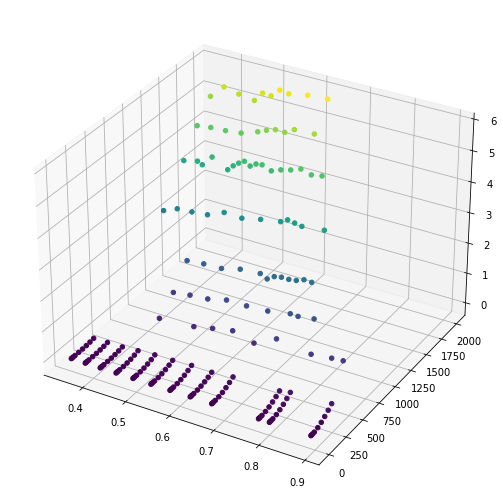

In [163]:
V, T, Evib = np.loadtxt('Evib.txt')

fig = plt.figure(figsize = (14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(V, T, Evib, c=Evib, alpha=1)

/usr/local/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=1,1 nx,ny=10,10 m=187 fp=264842124229.557312 s=167.660920
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


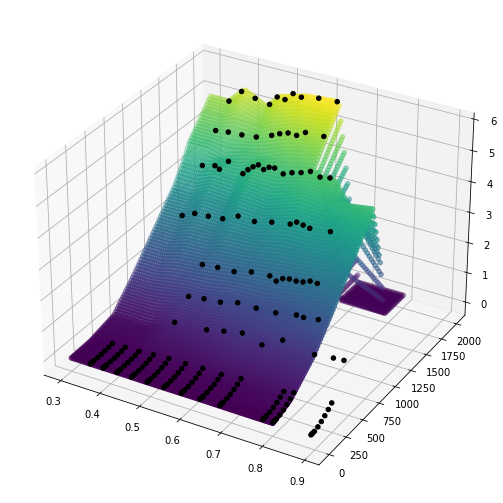

In [192]:
from scipy.interpolate import bisplrep, bisplev

tck = bisplrep(V, T, Evib, kx=1, ky=1)

Vi = np.linspace(0.3, 0.8, 100)
Ti = np.linspace(0, 2000, 100)
z = bisplev(Vi, Ti, tck).T

x, y = np.meshgrid(Vi, Ti)

fig = plt.figure(figsize = (14, 9))
ax = plt.axes(projection ='3d')

ax.scatter(V, T, Evib, c='k', alpha=1)
ax.scatter(x, y, z, c=z)

In [205]:
X = np.vstack([V, T]).T
yerr = 0.1
y = Evib

x_, y_ = np.meshgrid(Vi, Ti)
X_pred = np.vstack((x_.flatten(), y_.flatten())).T

In [206]:
import jaxopt
import jax
import jax.numpy as jnp
from tinygp import GaussianProcess, kernels, transforms


def train_gp(nparams, build_gp_func):
    @jax.jit
    def loss(params):
        return -build_gp_func(params).log_probability(y)

    params = {
        "log_amp": np.float64(0.0),
        "log_scale": np.zeros(nparams),
    }
    solver = jaxopt.ScipyMinimize(fun=loss)
    soln = solver.run(params)
    return build_gp_func(soln.params)


def build_gp_uncorr(params):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.exp(-params["log_scale"]), kernels.ExpSquared()
    )
    return GaussianProcess(kernel, X, diag=yerr**2)


uncorr_gp = train_gp(2, build_gp_uncorr)

In [207]:
y_pred = uncorr_gp.condition(y, X_pred).gp.loc.reshape(100, 100)

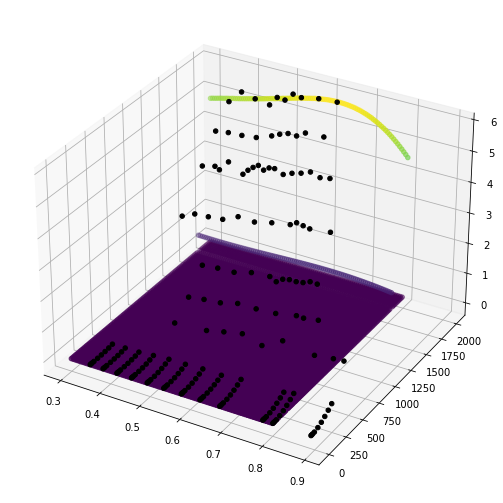

In [208]:
fig = plt.figure(figsize = (14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(V, T, Evib, c='k', alpha=1)
ax.scatter(x_.flatten(), y_.flatten(), y_pred.flatten(), c=y_pred)